# Teste base para experimentação com a base CICIDS2017.
Executando o algoritmo prequential delayed com **500 steps e 500 delay** .
## Pré-processamentos aplicados na base: 
- Colunas removidas: 'Source IP', 'Source Port', 'Destination IP', 'Destination Port','Timestamp';
- Removidas linhas com dados em branco/nulo;ss
- Coluna 'Label' numerizada - BENIGN = 0 / QUALQUER OUTRO VALOR = 1

In [1]:
import pandas as pd
import os
from river import tree
from river import metrics
from river import evaluate
from river import stream

C:\Users\andre\AppData\Local\Temp\ipykernel_6400\920285748.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
#read all csv files in dataset folder and combine them into one dataframe
def read_data():
    data = pd.DataFrame()
    for file in os.listdir('dataset'):
        if file.endswith('.csv'):
            data = pd.concat([data, pd.read_csv('dataset/' + file, index_col=0, encoding='ISO-8859-1')])
    return data

In [3]:
df = read_data()

C:\Users\andre\AppData\Local\Temp\ipykernel_6400\3000762906.py:6: DtypeWarning: Columns (0,1,3,6,84) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.concat([data, pd.read_csv('dataset/' + file, index_col=0, encoding='ISO-8859-1')])


In [4]:
df = df.reset_index(drop=True)

#strip whitespace from column names
df.columns = df.columns.str.strip()

#remove colunms not used in training
df.drop(['Source IP', 'Source Port', 'Destination IP', 'Destination Port','Timestamp'], axis=1, inplace=True)

#remove rows with missing values
df.dropna(inplace=True)

#numeric label
df['Label'] = df['Label'].transform(lambda x: int(x != 'BENIGN'))

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2383677 entries, 0 to 2673435
Data columns (total 79 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Protocol                     float64
 1   Flow Duration                float64
 2   Total Fwd Packets            float64
 3   Total Backward Packets       float64
 4   Total Length of Fwd Packets  float64
 5   Total Length of Bwd Packets  float64
 6   Fwd Packet Length Max        float64
 7   Fwd Packet Length Min        float64
 8   Fwd Packet Length Mean       float64
 9   Fwd Packet Length Std        float64
 10  Bwd Packet Length Max        float64
 11  Bwd Packet Length Min        float64
 12  Bwd Packet Length Mean       float64
 13  Bwd Packet Length Std        float64
 14  Flow Bytes/s                 float64
 15  Flow Packets/s               float64
 16  Flow IAT Mean                float64
 17  Flow IAT Std                 float64
 18  Flow IAT Max                 float64
 19  Flow 

In [6]:
X = df.drop('Label', axis=1)
y = df['Label']

data_stream = stream.iter_pandas(X=df.drop('Label', axis=1), y=df['Label'])

model = tree.ExtremelyFastDecisionTreeClassifier()

metrics = metrics.base.Metrics(
    metrics=[
        metrics.Accuracy(),
        metrics.Recall(),
        metrics.Precision(),
        metrics.F1()
        ]
    )

step_iterator = evaluate.iter_progressive_val_score(
    model=model,
    dataset= data_stream,
    metric=metrics,
    step=500,
    delay=500
)

metrics_df = pd.DataFrame()

In [7]:
def step_to_dataframe(evaluation_step):
    return pd.DataFrame({
        'accuracy': evaluation_step['Accuracy'].get(),
        'recall': evaluation_step['Recall'].get(),
        'precision': evaluation_step['Precision'].get(),
        'f1': evaluation_step['F1'].get(),
    }, index=[evaluation_step['Step']])

for step in step_iterator:
    metrics_df = pd.concat([metrics_df,step_to_dataframe(step)])

c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\river\stats\var.py:86: RuntimeWarning: invalid value encountered in scalar subtract
  self._S += w * (x - mean_old) * (x - mean_new)
c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\river\stats\mean.py:67: RuntimeWarning: invalid value encountered in scalar add
  self._mean += (w / self.n) * (x - self._mean)


In [8]:
import matplotlib.pyplot as plt

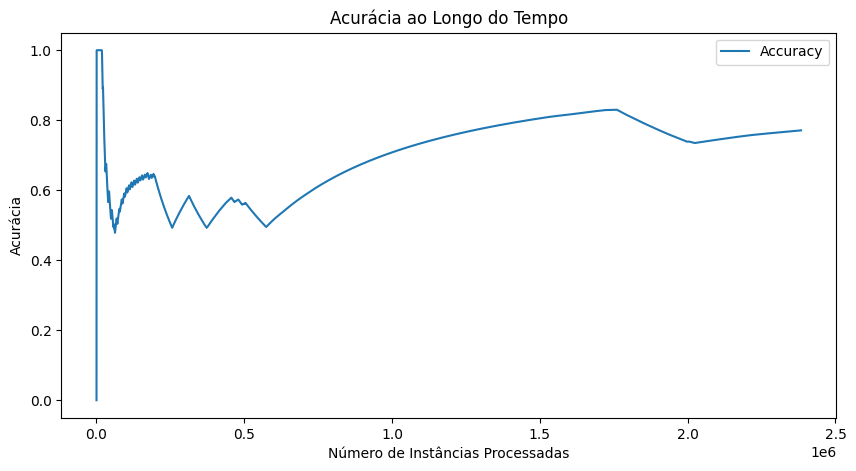

In [9]:
# Plotar a Acurácia
plt.figure(figsize=(10, 5))
plt.plot(metrics_df.index, metrics_df['accuracy'], label='Accuracy')
plt.xlabel('Número de Instâncias Processadas')
plt.ylabel('Acurácia')
plt.title('Acurácia ao Longo do Tempo')
plt.legend()
plt.show()

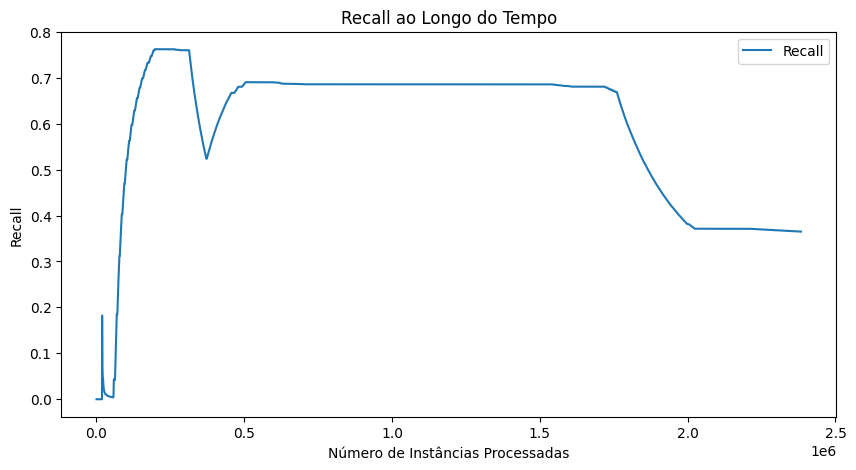

In [10]:
# Plotar o Recall
plt.figure(figsize=(10, 5))
plt.plot(metrics_df.index, metrics_df['recall'], label='Recall')
plt.xlabel('Número de Instâncias Processadas')
plt.ylabel('Recall')
plt.title('Recall ao Longo do Tempo')
plt.legend()
plt.show()

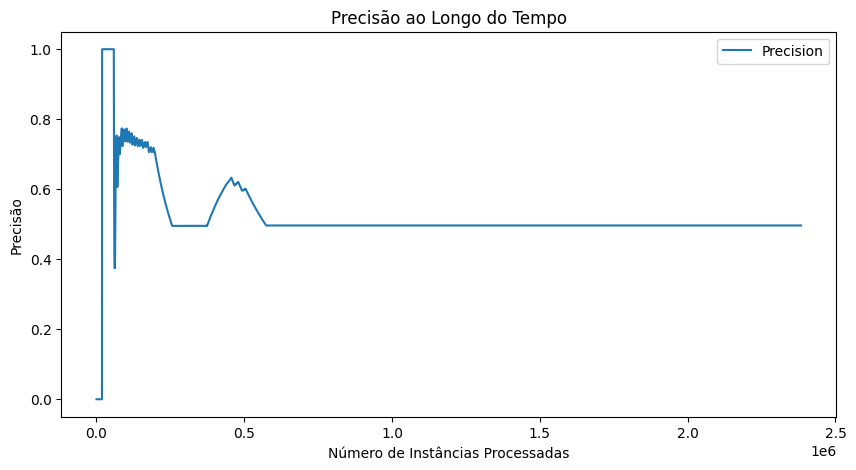

In [11]:
# Plotar a Precisão
plt.figure(figsize=(10, 5))
plt.plot(metrics_df.index, metrics_df['precision'], label='Precision')
plt.xlabel('Número de Instâncias Processadas')
plt.ylabel('Precisão')
plt.title('Precisão ao Longo do Tempo')
plt.legend()
plt.show()


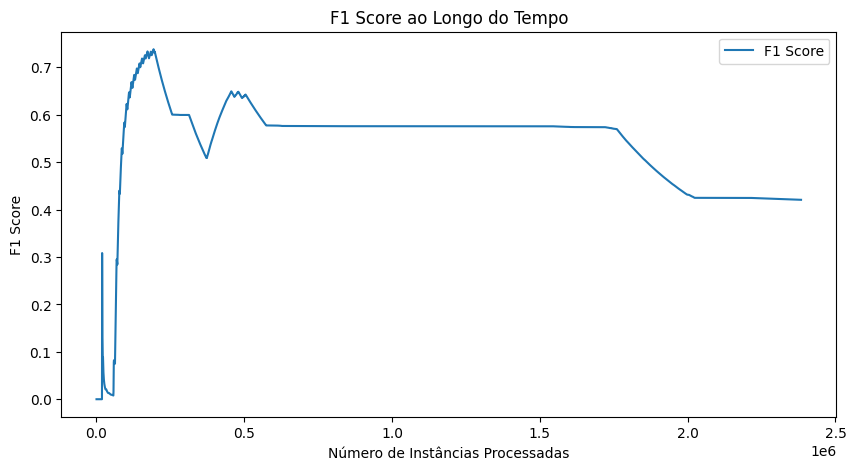

In [12]:
# Plotar o F1 Score
plt.figure(figsize=(10, 5))
plt.plot(metrics_df.index, metrics_df['f1'], label='F1 Score')
plt.xlabel('Número de Instâncias Processadas')
plt.ylabel('F1 Score')
plt.title('F1 Score ao Longo do Tempo')
plt.legend()
plt.show()